### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [4]:
data = read_text("spa-eng\spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [5]:
spa_eng = spa_eng[:50000,[0,1]]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [6]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.'],
       ['I appreciate your interest.', 'Agradezco tu interés.']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [7]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [8]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda'],
       ['I appreciate your interest', 'Agradezco tu interés']],
      dtype='<U332')

In [9]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [10]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [11]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [12]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
5        1    1
6        1    1
7        1    1
8        1    1
9        1    1
10       1    1
11       1    1
12       1    1
13       1    1
14       1    1
15       1    1
16       1    2
17       1    1
18       1    1
19       1    1
20       1    1
21       1    1
22       1    1
23       1    1
24       1    1
25       2    1
26       2    1
27       1    1
28       2    1
29       2    1
...    ...  ...
49970    6    6
49971    5    5
49972    6    6
49973    6    6
49974    6    4
49975    7    6
49976    6    5
49977    5    4
49978    6    4
49979    6    5
49980    8    6
49981    6    4
49982    6    6
49983    5    4
49984    5    4
49985    5    5
49986    6    4
49987    7    5
49988    7    7
49989    5    5
49990    7    6
49991    6    5
49992    7    6
49993    5    4
49994    6    5
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 

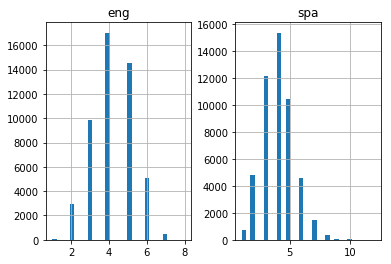

In [13]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [16]:
# prepare spatch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('spatch Vocabulary Size: %d' % spa_vocab_size)

spatch Vocabulary Size: 14196


In [17]:
print(spa_tokenizer.word_counts)

al', 2), ('sillas', 6), ('rapidísimo', 1), ('búsqueda', 3), ('direcciones', 1), ('asistió', 2), ('vengó', 2), ('gracia', 4), ('apostó', 3), ('abrochó', 1), ('razonar', 1), ('aseguró', 1), ('agachaba', 1), ('sugeriste', 1), ('investigó', 1), ('destacado', 1), ('necesitó', 1), ('treintas', 1), ('sucesor', 1), ('aparenta', 1), ('ocupa', 2), ('esteroides', 2), ('alistó', 2), ('llenó', 1), ('espacios', 1), ('concedió', 1), ('desvío', 1), ('británico', 1), ('admirador', 2), ('temperamento', 2), ('rendido', 1), ('regañina', 1), ('acceso', 2), ('maritales', 1), ('cantado', 3), ('heredó', 1), ('exesposo', 1), ('yerno', 1), ('compulsivo', 3), ('convicto', 1), ('amistosa', 1), ('imprudente', 2), ('desconocido', 2), ('parpadeando', 1), ('masticando', 2), ('cortando', 1), ('lamentarlo', 1), ('recostado', 1), ('rival', 1), ('porche', 1), ('podando', 1), ('firmando', 1), ('cabro', 1), ('encenagado', 1), ('conversando', 1), ('patadas', 1), ('tacho', 1), ('decoroso', 1), ('necesitado', 2), ('movimiento

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

<bound method Tokenizer.texts_to_sequences of <keras_preprocessing.text.Tokenizer object at 0x000001D5AD17AA08>>


### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [20]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [21]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [22]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [23]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [25]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14196
6942
8
8


In [26]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [27]:
filename = 'model1.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 57s 2ms/step - loss: 3.9498 - val_loss: 3.6200

Epoch 00001: val_loss improved from inf to 3.62003, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 46s 1ms/step - loss: 3.2580 - val_loss: 3.2574

Epoch 00002: val_loss improved from 3.62003 to 3.25741, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 47s 1ms/step - loss: 3.1166 - val_loss: 3.1339

Epoch 00003: val_loss improved from 3.25741 to 3.13391, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 46s 1ms/step - loss: 2.9743 - val_loss: 3.0262

Epoch 00004: val_loss improved from 3.13391 to 3.02625, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 46s 1ms/step - loss: 2.8505 - val_loss: 2.8750

Epoch 00005: val_loss improved from 3.02625 to 2.87505, savi

Let's compare the training loss and the validation loss.

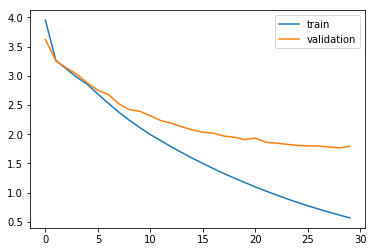

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [29]:
model = load_model('model1.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [30]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [31]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [32]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [33]:
pd.set_option('display.max_colwidth', 200)

In [34]:
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,theyre very
1,conozco a tom,i know tom
2,puedes negarte,you may return
3,eso es privado,thats is nonsense
4,tom saltó desde su asiento,tom jumped on his
5,¿jamás has vendido un auto,did you look a car
6,¿cuántos hijos tienes,how many kids do you have
7,no te dejaré hacerlo,i wont not you
8,¿no es hermoso,isnt it beautiful
9,mi loro murió ayer,my mother died there


In [35]:
pred_df.tail(15)

,actual,predicted
9985,¿tom y mary saben,does tom know help mary
9986,tom puede ser burdo,tom can be useful
9987,¿querés probarlo,do you want to try it
9988,¿sabes quién era,do you know who it was
9989,también es una belleza,its a excellent
9990,quiero a su hija,i want your bag
9991,él da clases de inglés,he often from cry
9992,me quedé dormido,i fell asleep
9993,él es pobre como pocos,he is as
9994,¿dónde está mi camisa,wheres my


In [36]:
pred_df.sample(15)

,actual,predicted
498,ve a cepillarte los dientes,go to your teeth
2357,dale esta copia a tom,call tom
4194,te entiendo,i remember you
8156,estaba furioso,i was embarrassed
1427,creo que estás totalmente equivocado,i think youre mistaken
4777,está haciendo un dibujo,hes is under a
1340,bush estudió el problema,he turned in the
3869,iremos después de comer,well go eat
5919,¡qué hermoso vestido,what a beautiful trip
3303,no importa,it doesnt matter


## Con 2 capas LSTM

In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [25]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [39]:
filename = 'model2.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[512,8,6942] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/truediv}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss_2/mul/_695]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[512,8,6942] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/truediv}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model2.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.sample(15)

## Simple RDD

In [24]:
from keras.layers import SimpleRNN
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [25]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 216)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [26]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 24s 756us/step - loss: 5.9231 - val_loss: 5.5047

Epoch 00001: val_loss improved from inf to 5.50468, saving model to model3.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 22s 676us/step - loss: 5.2775 - val_loss: 5.1787

Epoch 00002: val_loss improved from 5.50468 to 5.17874, saving model to model3.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 22s 684us/step - loss: 4.8382 - val_loss: 4.7497

Epoch 00003: val_loss improved from 5.17874 to 4.74973, saving model to model3.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 22s 675us/step - loss: 4.4064 - val_loss: 4.4283

Epoch 00004: val_loss improved from 4.74973 to 4.42830, saving model to model3.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 22s 675us/step - loss: 4.0907 - val_loss: 4.2419

Epoch 00005: val_loss improved from 4.42830 to

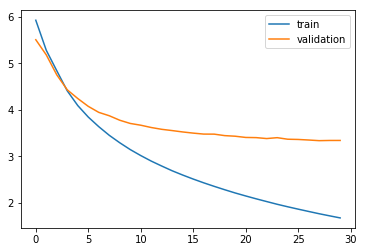

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [28]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [29]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [30]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [31]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [32]:
pd.set_option('display.max_colwidth', 200)

In [33]:
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,they are very
1,conozco a tom,i know tom
2,puedes negarte,you may return
3,eso es privado,thats is legal
4,tom saltó desde su asiento,tom put his
5,¿jamás has vendido un auto,were it on in car
6,¿cuántos hijos tienes,how many do you have
7,no te dejaré hacerlo,i wont do you
8,¿no es hermoso,is it hot
9,mi loro murió ayer,my wife looked crying


In [34]:
pred_df.tail(15)

,actual,predicted
9985,¿tom y mary saben,did tom know mary
9986,tom puede ser burdo,tom can be sick
9987,¿querés probarlo,do you want to do it
9988,¿sabes quién era,do you know who he was
9989,también es una belleza,its a big
9990,quiero a su hija,i want your respect
9991,él da clases de inglés,he will to cry
9992,me quedé dormido,i got asleep
9993,él es pobre como pocos,he is as
9994,¿dónde está mi camisa,wheres my father


In [35]:
pred_df.sample(15)

,actual,predicted
2189,sé que él sabe dibujar,i know it was it
5558,¿qué es lo que motiva a tom,what tom to
6247,me indigna,you need
4435,no estaba allí la semana pasada,i was no up the
5645,a ella le gustan los tigres,she likes to
15,no tengo miedo,im not afraid
8159,vi al padre de tom,i saw tom dog
2874,ellos encontrarán a tom,well ask tom
1970,¿querés esta camisa,do you want this shirt
3877,¡no se olvide de nosotros,dont be me again


# GRU 2 capas

In [25]:
from keras.layers import GRU
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units, return_sequences=True))
    model.add(GRU(units, return_sequences=True))
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [26]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 524)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [27]:
filename = 'model3.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 50s 2ms/step - loss: 5.8367 - val_loss: 5.2999

Epoch 00001: val_loss improved from inf to 5.29991, saving model to model3.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 44s 1ms/step - loss: 5.0317 - val_loss: 4.8945

Epoch 00002: val_loss improved from 5.29991 to 4.89452, saving model to model3.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 45s 1ms/step - loss: 4.5490 - val_loss: 4.5051

Epoch 00003: val_loss improved from 4.89452 to 4.50506, saving model to model3.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 44s 1ms/step - loss: 4.1392 - val_loss: 4.2362

Epoch 00004: val_loss improved from 4.50506 to 4.23616, saving model to model3.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 45s 1ms/step - loss: 3.7955 - val_loss: 4.0045

Epoch 00005: val_loss improved from 4.23616 to 4.00452, 

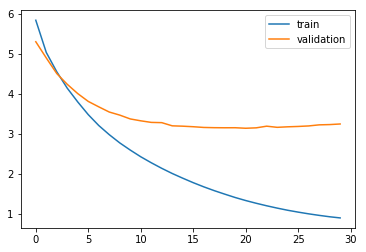

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [29]:
model = load_model('model2.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [30]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [31]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [32]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [33]:
pd.set_option('display.max_colwidth', 200)

In [34]:
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,they are very
1,conozco a tom,i know tom
2,puedes negarte,you may return
3,eso es privado,thats is legal
4,tom saltó desde su asiento,tom put his
5,¿jamás has vendido un auto,were it on in car
6,¿cuántos hijos tienes,how many do you have
7,no te dejaré hacerlo,i wont do you
8,¿no es hermoso,is it hot
9,mi loro murió ayer,my wife looked crying


In [35]:
pred_df.tail(15)

,actual,predicted
9985,¿tom y mary saben,did tom know mary
9986,tom puede ser burdo,tom can be sick
9987,¿querés probarlo,do you want to do it
9988,¿sabes quién era,do you know who he was
9989,también es una belleza,its a big
9990,quiero a su hija,i want your respect
9991,él da clases de inglés,he will to cry
9992,me quedé dormido,i got asleep
9993,él es pobre como pocos,he is as
9994,¿dónde está mi camisa,wheres my father


In [36]:
pred_df.sample(15)

,actual,predicted
1304,tom se sentó junto a mary,tom sat next to mary
5407,yo soy profesor,im a teacher
9981,preguntaremos diplomáticamente,are you watching
85,tu pelo volverá a crecer,his name will come
8006,lamento llegar tarde,im sorry being late
3133,ella tiene habilidades psíquicas,she has broad cancer
420,somos adultos,were restless
1931,no me gusta la primavera,i dont like this
5537,¿qué estaban buscando,what were you doing for
6524,voy a estar libre,ill be around
